In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio
import scipy.signal
import scipy.interpolate
from scipy.interpolate import interp1d
import pylops
import seaborn as sns
import cmocean as cm
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [2]:
print('Numpy', np.__version__)
print('Scipy', scipy.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('Pylops', pylops.__version__)

Numpy 1.24.2
Scipy 1.10.1
Pandas 1.5.3
Matplotlib 3.7.1
Pylops 2.0.0


In [3]:
#filename = 'Sismica/R0258_3D_SPEC_BC_5_10_60_ANISOTROPIC.3D.PSDM.3_noScan_SubvolBackground_Time.sgy'
filename = 'Sismica/Denoised_CNN_BP.sgy'

with segyio.open(filename) as f:
    # Memory mapping the segy file
    f.mmap()
    
    # Verify the dimensions of 3D seismic data
    shape = (len(f.ilines), len(f.xlines), len(f.samples))
    
    # Inlines information
    il_start, il_end = f.ilines[0], f.ilines[-1]
    il_step = f.ilines[1] - f.ilines[0]
    
    # Crosslines information
    xl_start, xl_end = f.xlines[0], f.xlines[-1]
    xl_step = f.xlines[1] - f.xlines[0]
    
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    
    # Effectively stores all data into array 'traces'
    traces = f.trace.raw[:]

print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', shape)
print('Inline start:', il_start, '    ', 'Inline end:', il_end, '    ', 'Inline step:', il_step)
print('Crossline start:', xl_start, '    ', 'Crossline end:', xl_end, '    ', 'Crossline step:', xl_step)
print('Number of traces [n_il*n_xl]:', n_traces)
print('Sample rate [ms]:', sample_rate)
print('Number of samples by trace:', n_samples)
print('Two-way-time array:', twt)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  (971, 1048, 1751)
Inline start: 2800      Inline end: 3770      Inline step: 1
Crossline start: 4580      Crossline end: 5627      Crossline step: 1
Number of traces [n_il*n_xl]: 1017608
Sample rate [ms]: 4.0
Number of samples by trace: 1751
Two-way-time array: [0.000e+00 4.000e+00 8.000e+00 ... 6.992e+03 6.996e+03 7.000e+03]


In [4]:
data = traces.reshape(shape)

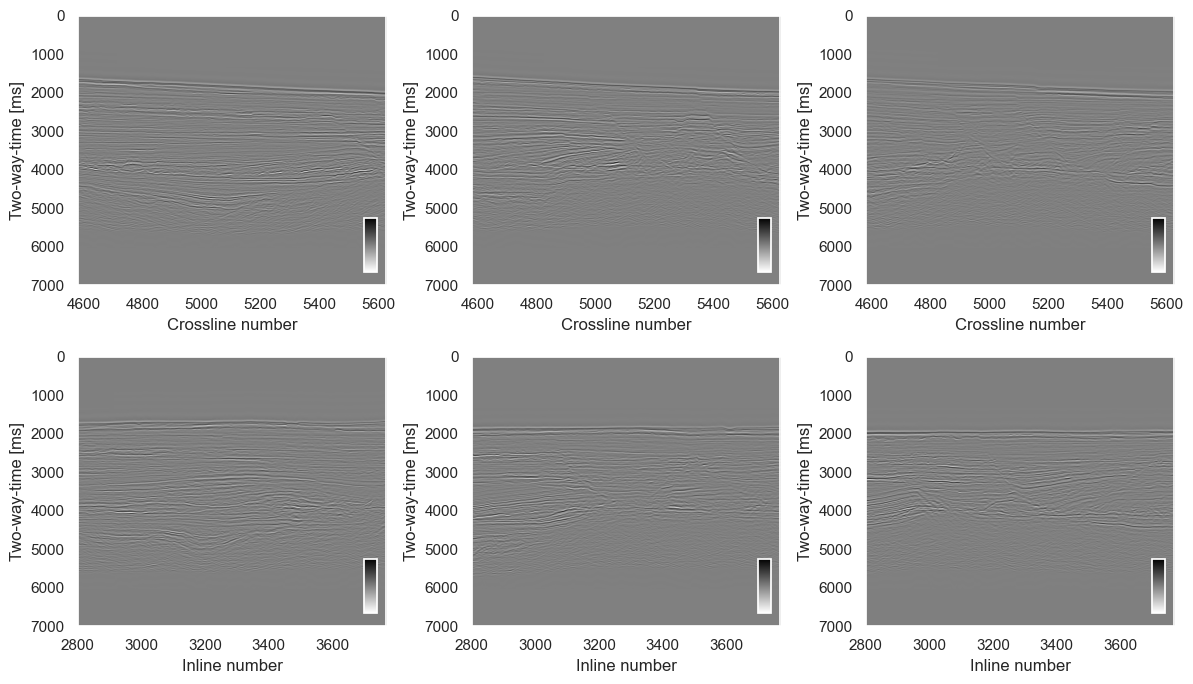

In [5]:
# Visualizing 3 inlines and 3 crosslines

il1 = (2900 - il_start) // il_step
il2 = (3300 - il_start) // il_step
il3 = (3600 - il_start) // il_step
xl1 = (4800 - xl_start) // xl_step
xl2 = (5200 - xl_start) // xl_step
xl3 = (5500 - xl_start) // xl_step

extent_il = (xl_start, xl_end, twt[-1], twt[0])
extent_xl = (il_start, il_end, twt[-1], twt[0])

fig, ax = plt.subplots(2, 3, figsize=(12, 7))

c1=ax[0, 0].imshow(data[int(il1), :, :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
c2=ax[0, 1].imshow(data[int(il2), :, :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
c3=ax[0, 2].imshow(data[int(il3), :, :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
c4=ax[1, 0].imshow(data[:, int(xl1), :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_xl)
c5=ax[1, 1].imshow(data[:, int(xl2), :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_xl)
c6=ax[1, 2].imshow(data[:, int(xl3), :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_xl)

for axs in fig.get_axes():
    axs.set_ylabel('Two-way-time [ms]')
    axin = axs.inset_axes([0.93, 0.05, 0.04, 0.2])
    axin.grid(False)
    axin.set(xticks=[],
              yticks=[])
    plt.colorbar(c1, cax=axin, ticks=[])
    axs.grid(False)
for axs in (ax[0, 0], ax[0, 1], ax[0, 2]):
    axs.set_xlabel('Crossline number')
for axs in (ax[1, 0], ax[1, 1], ax[1, 2]):
    axs.set_xlabel('Inline number')


    
plt.tight_layout()

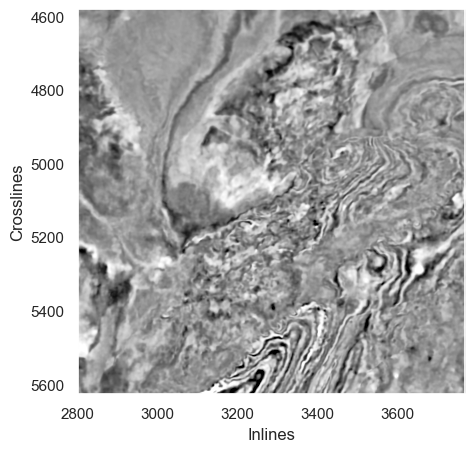

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(data[:, :, 800].T, aspect='auto', vmin=-15000, vmax=15000, cmap='Greys',
           extent=(il_start, il_end, xl_end, xl_start))
ax.set_xlabel('Inlines')
ax.set_ylabel('Crosslines')
ax.grid(False)

In [7]:
lowf = 'Impedancia/TIME_Low_Frequency_Model_6Hz_497Blind.sgy'

with segyio.open(lowf) as f:
    # Memory mapping the segy file
    f.mmap()
    
    # Verify the dimensions of 3D seismic data
    shape_lowf = (len(f.ilines), len(f.xlines), len(f.samples))

    # Inlines information
    il_start_lowf, il_end_lowf = f.ilines[0], f.ilines[-1]
    il_step_lowf = f.ilines[1] - f.ilines[0]
    
    # Crosslines information
    xl_start_lowf, xl_end_lowf = f.xlines[0], f.xlines[-1]
    xl_step_lowf = f.xlines[1] - f.xlines[0]
    
    # Get basic attributes
    n_traces_lowf = f.tracecount
    sample_rate_lowf = segyio.tools.dt(f) / 1000
    n_samples_lowf = f.samples.size
    twt_lowf = f.samples
    
    # Effectively stores all data into array 'traces'
    traces_lowf = f.trace.raw[:]
    
print('Low frequency model information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', shape_lowf)
print('Inline start:', il_start_lowf, '    ', 'Inline end:', il_end_lowf, '    ', 'Inline step:', il_step_lowf)
print('Crossline start:', xl_start_lowf, '    ', 'Crossline end:', xl_end_lowf, '    ', 'Crossline step:', xl_step_lowf)
print('Number of traces [n_il*n_xl]:', n_traces_lowf)
print('Sample rate [ms]:', sample_rate_lowf)
print('Number of samples by trace:', n_samples_lowf)
print('Two-way-time array:', twt_lowf)

Low frequency model information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  (971, 1051, 1751)
Inline start: 2800      Inline end: 3770      Inline step: 1
Crossline start: 4580      Crossline end: 5630      Crossline step: 1
Number of traces [n_il*n_xl]: 1020521
Sample rate [ms]: 4.0
Number of samples by trace: 1751
Two-way-time array: [0.000e+00 4.000e+00 8.000e+00 ... 6.992e+03 6.996e+03 7.000e+03]


In [8]:
lowf = np.reshape(traces_lowf, shape_lowf)

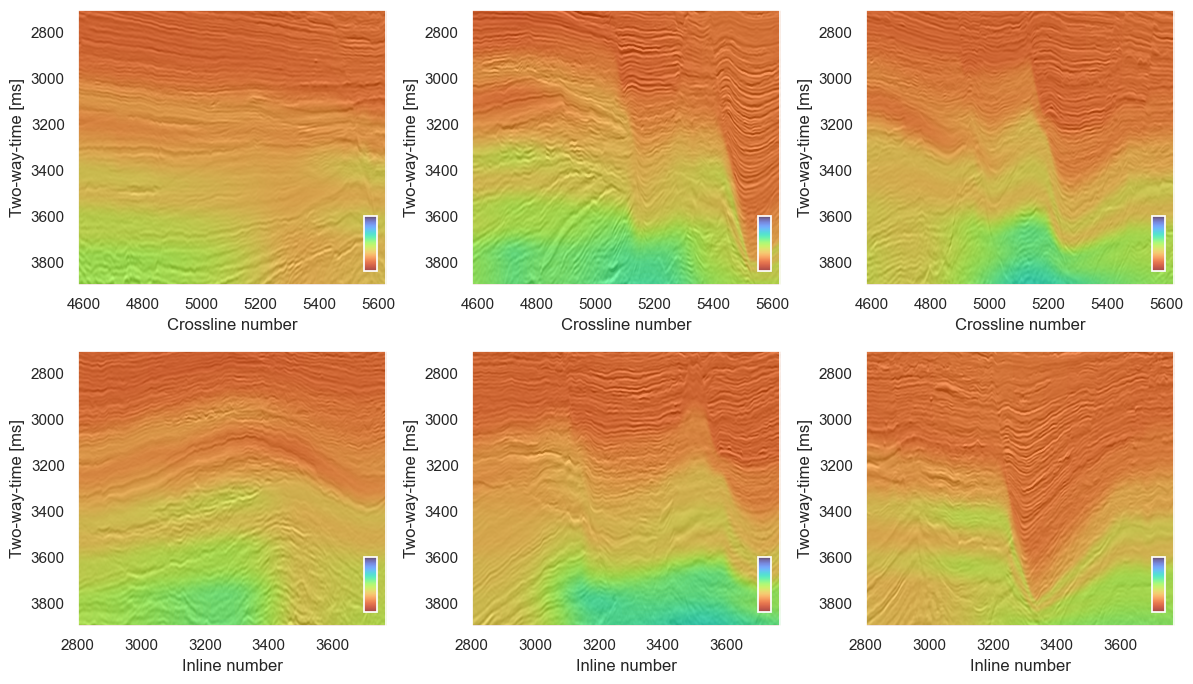

In [9]:
# Visualizing 3 inlines and 3 crosslines

il1 = (2900 - il_start) // il_step
il2 = (3300 - il_start) // il_step
il3 = (3600 - il_start) // il_step
xl1 = (4800 - xl_start) // xl_step
xl2 = (5200 - xl_start) // xl_step
xl3 = (5500 - xl_start) // xl_step

fig, ax = plt.subplots(2, 3, figsize=(12, 7))

ax[0, 0].imshow(data[int(il1), :, :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
c1=ax[0, 0].imshow(lowf[int(il1), :, :].T, aspect='auto',
                cmap='turbo_r', vmin=3000, vmax=15000, extent=extent_il, alpha=0.7)

ax[0, 1].imshow(data[int(il2), :, :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
ax[0, 1].imshow(lowf[int(il2), :, :].T, aspect='auto',
                cmap='turbo_r', vmin=3000, vmax=15000, extent=extent_il, alpha=0.7)

ax[0, 2].imshow(data[int(il3), :, :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
ax[0, 2].imshow(lowf[int(il3), :, :].T, aspect='auto',
                cmap='turbo_r', vmin=3000, vmax=15000, extent=extent_il, alpha=0.7)

ax[1, 0].imshow(data[:, int(xl1), :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_xl)
ax[1, 0].imshow(lowf[:, int(xl1), :].T, aspect='auto',
                cmap='turbo_r', vmin=3000, vmax=15000, extent=extent_xl, alpha=0.7)

ax[1, 1].imshow(data[:, int(xl2), :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_xl)
ax[1, 1].imshow(lowf[:, int(xl2), :].T, aspect='auto',
                cmap='turbo_r', vmin=3000, vmax=15000, extent=extent_xl, alpha=0.7)

ax[1, 2].imshow(data[:, int(xl3), :].T, aspect='auto',
                cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_xl)
ax[1, 2].imshow(lowf[:, int(xl3), :].T, aspect='auto',
                cmap='turbo_r', vmin=3000, vmax=15000, extent=extent_xl, alpha=0.7)

for axs in fig.get_axes():
    axs.set_ylim(3900, 2700)
    axs.set_ylabel('Two-way-time [ms]')
    axs.grid(False)
    axin = axs.inset_axes([0.93, 0.05, 0.04, 0.2])
    axin.grid(False)
    axin.set(xticks=[],
              yticks=[])
    plt.colorbar(c1, cax=axin, ticks=[])
for axs in (ax[0, 0], ax[0, 1], ax[0, 2]):
    axs.set_xlabel('Crossline number')
for axs in (ax[1, 0], ax[1, 1], ax[1, 2]):
    axs.set_xlabel('Inline number')
    
plt.tight_layout()

In [10]:
eoceno = pd.read_csv("Superficies/EocenoSuperior_SubvolBackground_Time.dat",
                     sep='\s+', skiprows=0, usecols=(0, 1, 2), names=['X', 'Y', 'Z'])

In [11]:
paleoceno = pd.read_csv("Superficies/Paleoceno_SubvolBackground_Time.dat",
                        sep='\s+', skiprows=0, usecols=(0, 1, 2), names=['X', 'Y', 'Z'])

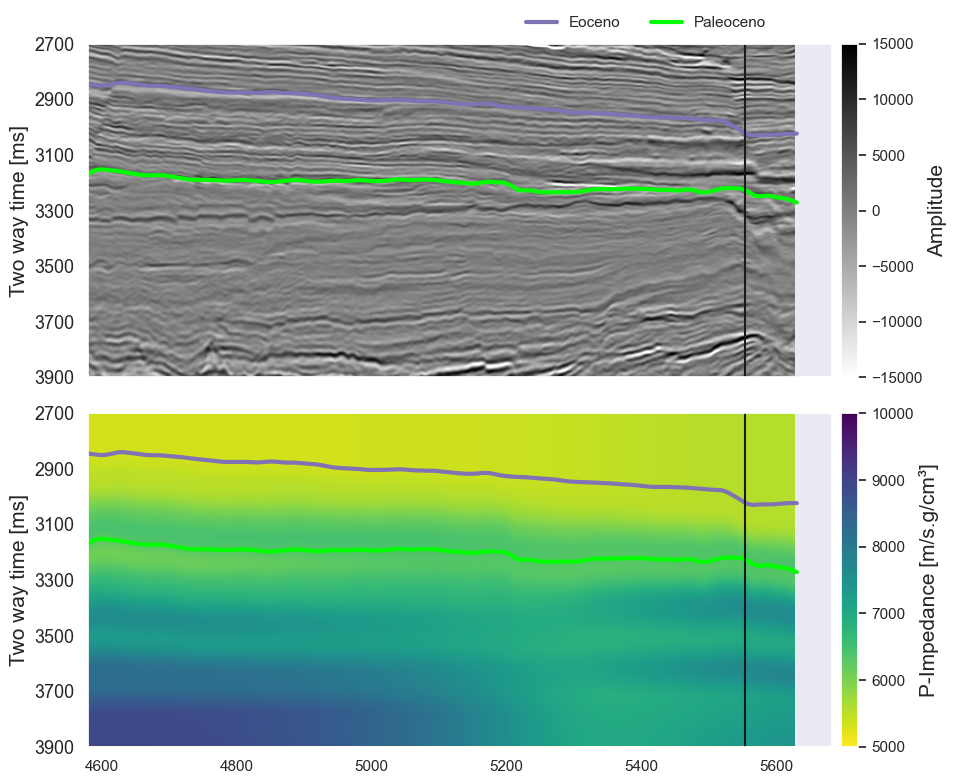

In [12]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

c=axs[0].imshow(data[2862 - 2800, :, :].T, aspect='auto', cmap='gray_r', vmin=-15000, vmax=15000, extent=extent_il)
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(lowf[2862 - 2800, :, :].T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=10000, extent=extent_il)
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)


for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3900, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3901, 200))
    ax.set_yticklabels(np.arange(2700, 3901, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')
    
    ax.set_ylabel("Two way time [ms]", fontsize=15)
    
    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()
#plt.savefig('Figures/lowfrequency_497.png', dpi=200, bbox_inches='tight')

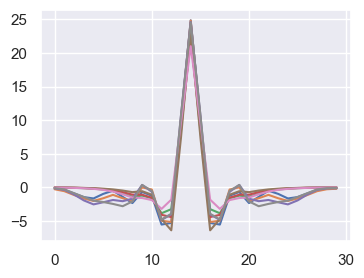

In [13]:
# Wavelet

path = "Wavelets/"
wavs = np.zeros((8, 30))
for idx, file in enumerate(os.listdir(path)):

    wavs[idx, :] = np.squeeze(pd.read_csv(path+file, skiprows=8).to_numpy())

plt.figure(figsize=(4, 3))
for i in range(8):
    plt.plot(wavs[i, :])

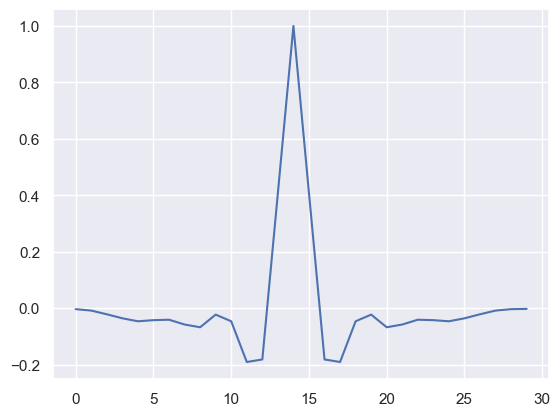

In [14]:
wav = np.mean(wavs, axis=0)
wav = wav / np.max(abs(wav))
plt.plot(wav)

In [15]:
np.save('wav_avg.npy', wav)

In [16]:
nfft = 1024
dt0 = 4e-3
fwest = np.fft.fftfreq(nfft, d=dt0)
est_fft = np.abs(np.fft.fft(wav, nfft, axis=0))
est_fft = (est_fft - np.min(est_fft)) / (np.max(est_fft) - np.min(est_fft))

(0.0, 1.4)

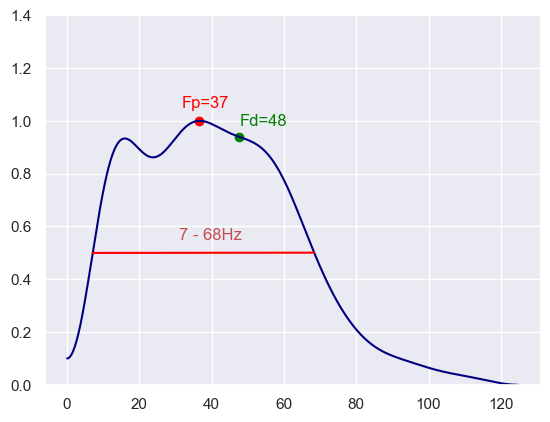

In [17]:
plt.plot(fwest[:nfft//2], est_fft[:nfft//2], color='navy')
plt.plot([fwest[:nfft//2][29], fwest[:nfft//2][280]],
         [est_fft[:nfft//2][29], est_fft[:nfft//2][280]],
         color='red')
plt.text(31, 0.55, f'{fwest[:nfft//2][29]:.0f} - {fwest[:nfft//2][280]:.0f}Hz', color='r')
plt.scatter(fwest[:nfft//2][150], est_fft[:nfft//2][150], color='red')
plt.scatter(fwest[:nfft//2][150]*1.3, 0.94, color='green')
plt.text(fwest[:nfft//2][150]-5, 1.05, f'Fp={fwest[:nfft//2][150]:.0f}', color='red')
plt.text(fwest[:nfft//2][150]*1.3, 0.98, f'Fd={1.3*fwest[:nfft//2][150]:.0f}', color='green')
plt.ylim(0, 1.4)

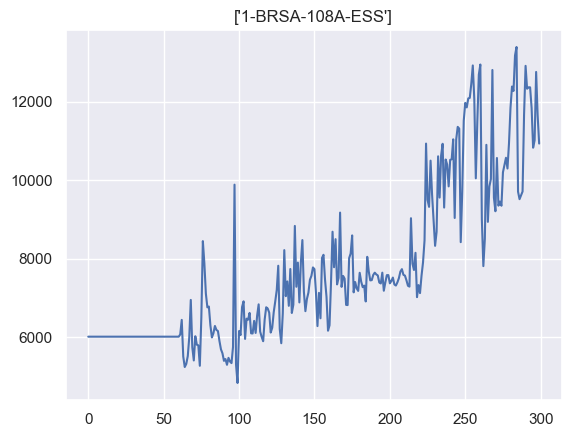

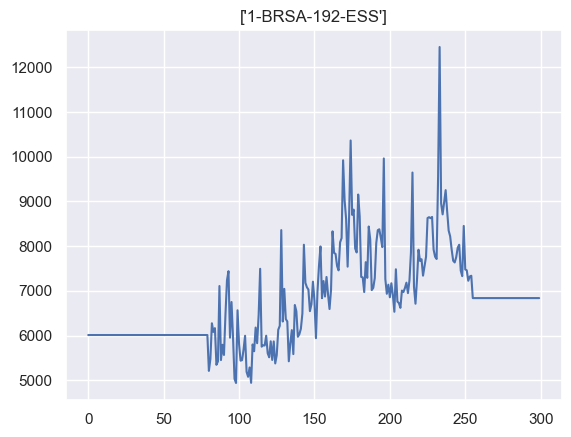

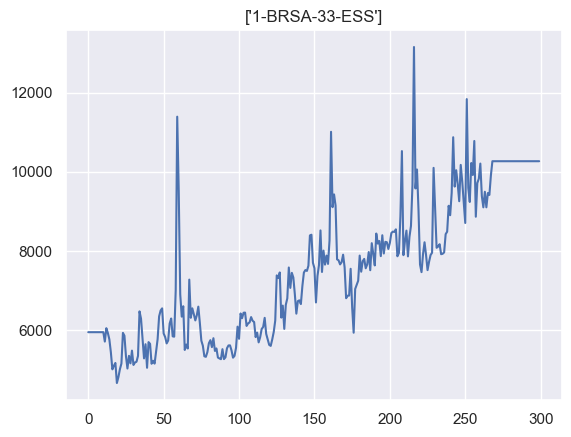

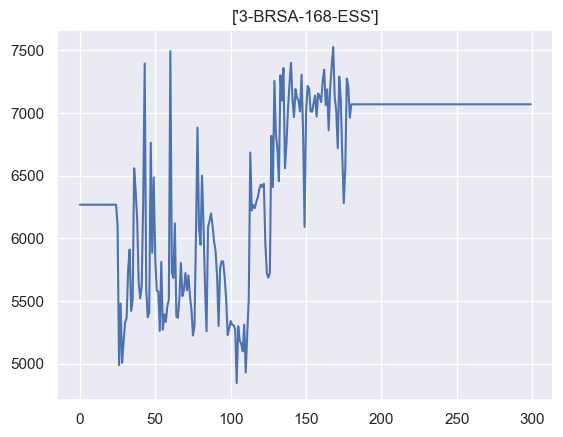

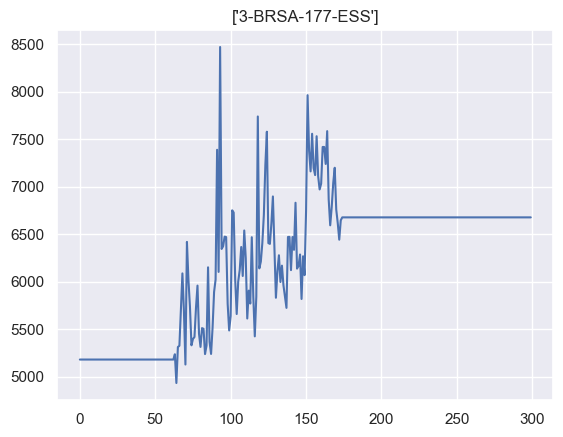

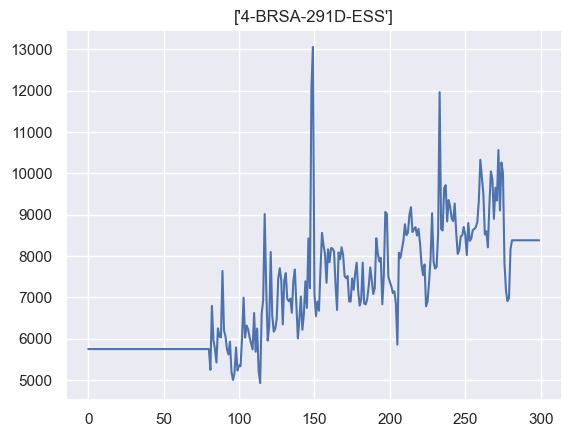

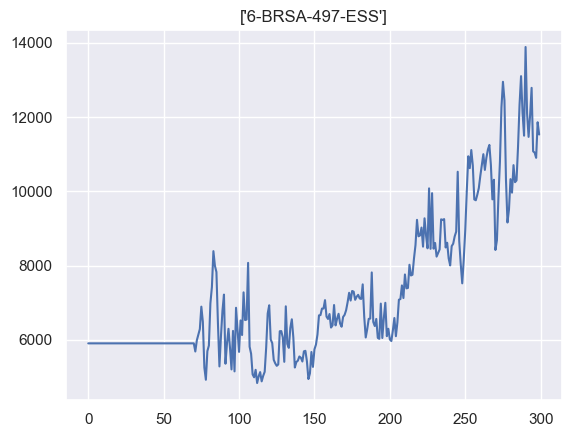

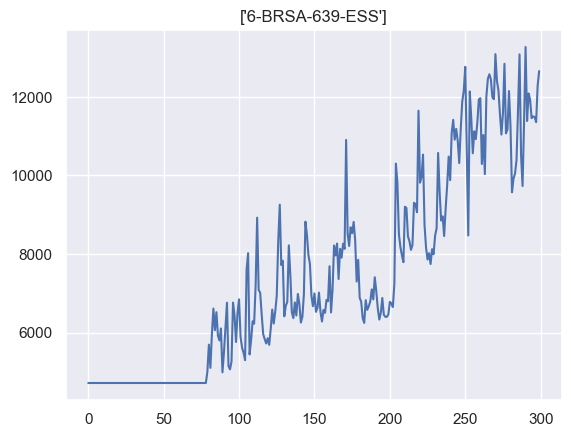

In [18]:
path = "Pocos/IP_UPS/"

df = pd.DataFrame()
names = ['Depth', 'VP', 'RHO', 'VP_4Hz', 'RHO_4Hz', 'VP_6Hz', 'RHO_6Hz',
         'VP_8Hz', 'RHO_8Hz', 'IP', 'IP_4Hz', 'IP_6Hz', 'IP_8Hz']

for file in os.listdir(path):
    well = pd.read_csv(path+file, sep='\s+', skiprows=1, names=names)
    # Replacing nans
    well.replace(1e30, np.nan, inplace=True)
    # Naming well
    well['WELL'] = file.split('_')[0]
    tdr = pd.read_csv(f'Pocos/TimeVsDepth/{file.split("_")[0]}.dat', skiprows=14, sep='\s+',
                      names=['MD', 'TVD', 'TVDSS', 'TWT', 'VINT'])
    interp_tdr = interp1d(tdr['MD'], tdr['TWT'], fill_value='extrapolate', bounds_error=False)
    t_well = interp_tdr(well.Depth)
    
    new_samples = np.arange(2700, 3900, 4)
    interp2 = interp1d(t_well, well.IP, bounds_error=False, fill_value='extrapolate')
    ip_ups = interp2(new_samples)
    ip_ups = scipy.ndimage.gaussian_filter(ip_ups, sigma=0.5)

    arr = np.array([new_samples, ip_ups])
    nwell = pd.DataFrame(arr.T, columns=['TWT', 'IP_UPS'])
    nwell['WELL'] = file.split('_')[0]
    nwell['IP_UPS'] = nwell['IP_UPS'].fillna(method='bfill').fillna(method='ffill')
    plt.title(nwell['WELL'].unique())
    plt.plot(nwell['IP_UPS'])
    plt.show()
    # Concatenate
    df = pd.concat([df, nwell], ignore_index=True)

In [19]:
# Inverting at well 55 inline

# Seismic amplitude section
amp = data[2862 - 2800, :, 675:975].T
print("Shape of data [n_samples, n_traces]:", amp.shape)
# Log of the low frequency model of impedance
mback = np.log(lowf[2862 - 2800, :-3, 675:975].T)
# Wavelet operator
nz, nx = amp.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace
minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,
    y=amp.ravel() / 30000,
    Regs=None,
    epsI=5e-1,
    x0=mback.ravel(),
    engine='scipy',
    **dict(maxiter=1000))
minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))

Shape of data [n_samples, n_traces]: (300, 1048)


In [20]:
df.loc[(df.WELL=='6-BRSA-497-ESS') & (df.TWT < 3100), 'IP_UPS'] = np.nan
img = np.tile(df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, (100, 1))

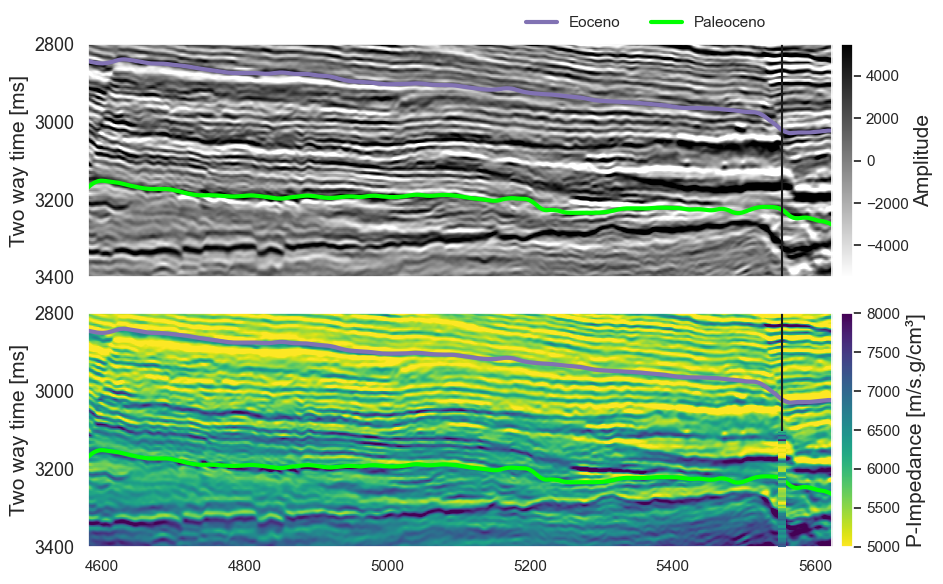

In [21]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

c=axs[0].imshow(amp, aspect='auto', cmap='gray_r', vmin=-5500, vmax=5500, extent=[xl_start, xl_end-3, 3900, 2700])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(minv_tbt, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000, extent=[xl_start, xl_end-3, 3900, 2700])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)
axs[1].imshow(img.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000,
             extent=(5553-5, 5553+5, 3900, 2700), zorder=20)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3400, 2800)
    ax.set_xlim(xl_start, xl_end-3)
    ax.set_yticks(np.arange(2800, 3401, 200))
    ax.set_yticklabels(np.arange(2800, 3401, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')
    
    ax.set_ylabel("Two way time [ms]", fontsize=15)
    
    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()

plt.savefig('Figures/inversion_497.png', dpi=200, bbox_inches='tight')

In [22]:
print('Correlation coefficient of trace-by-trace inversion:',
      scipy.stats.pearsonr(df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS[100:200],
                           minv_tbt[:, 5553-xl_start][100:200])[0]
)

Correlation coefficient of trace-by-trace inversion: 0.5478424175860348


Text(0, 0.5, 'Acoustic impedance [m/s.g/cm³]')

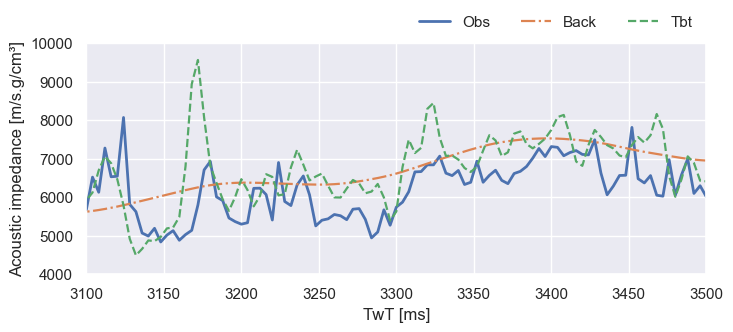

In [23]:
plt.figure(figsize=(8, 3))

plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, label='Obs', lw=2.0)
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, np.exp(mback[:, 5553-xl_start]), label='Back', lw=1.6, ls='-.')
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, minv_tbt[:, 5553-xl_start], label='Tbt', lw=1.6, ls='--')
#plt.plot(new_twt, minv_hop[:, 1469-new_xl_start], label='Hor', lw=1.6, ls='--')
#plt.plot(new_twt, minv_dop[:, 1469-new_xl_start], label='Dir', lw=1.6, ls='--')
#plt.plot(new_twt, bsd[1269 - new_il_start, 1469-new_xl_start, :], label='Petrel', lw=1.6, ls='--')

plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), edgecolor='w', facecolor='w', ncol=5)

plt.xlim(3100, 3500)
plt.ylim(4000, 10000)
plt.xlabel('TwT [ms]')
plt.ylabel('Acoustic impedance [m/s.g/cm³]')
#plt.savefig('Figures/inversion_497_well.png', dpi=200, bbox_inches='tight')

(3770.0, 2800.0)

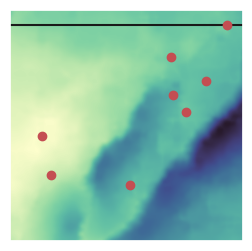

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(paleoceno['Y'], paleoceno['X'], c=paleoceno['Z'], s=1, cmap=cm.cm.deep)
ax.axhline(2862, color='k')
ax.scatter(5118, 3534, color='r', zorder=20)
ax.scatter(5462, 3100, color='r', zorder=20)
ax.scatter(4722, 3331, color='r', zorder=20)
ax.scatter(4765, 3493, color='r', zorder=20)
ax.scatter(5305, 2996, color='r', zorder=20)
ax.scatter(5370, 3230, color='r', zorder=20)
ax.scatter(5553, 2862, color='r', zorder=20)
ax.scatter(5313, 3157, color='r', zorder=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xl_start, xl_end-3)
ax.set_ylim(il_end, il_start)

Text(0, 0.5, 'Inverted acoustic impedance [m/s.g/cm³]')

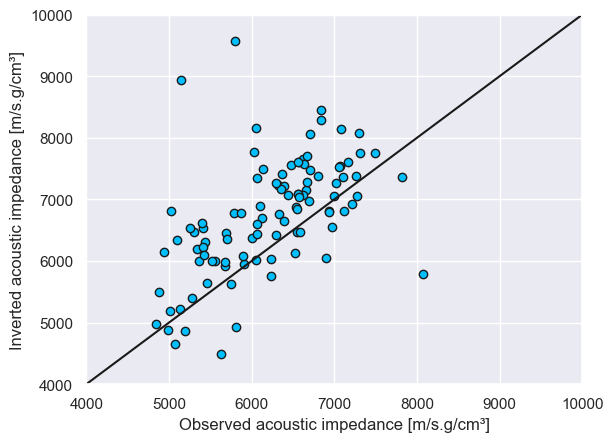

In [25]:
plt.plot([4000, 10000], [4000, 10000], color='k')
plt.scatter(df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS[100:200],
            minv_tbt[:, 5553-xl_start][100:200], color='deepskyblue', edgecolor='k')
plt.xlim(4000, 10000)
plt.ylim(4000, 10000)
plt.xlabel('Observed acoustic impedance [m/s.g/cm³]')
plt.ylabel('Inverted acoustic impedance [m/s.g/cm³]')

In [26]:
# Inverting at well 55 inline

# Seismic amplitude section
amp = data[3100 - 2800, :, 675:975].T
print("Shape of data [n_samples, n_traces]:", amp.shape)
# Log of the low frequency model of impedance
mback = np.log(lowf[3100 - 2800, :-3, 675:975].T)
# Wavelet operator
nz, nx = amp.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace
minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,
    y=amp.ravel() / 30000,
    Regs=None,
    epsI=5e-1,
    x0=mback.ravel(),
    engine='scipy',
    **dict(maxiter=1000))
minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))

Shape of data [n_samples, n_traces]: (300, 1048)


In [27]:
img = np.tile(df.loc[df.WELL=='1-BRSA-192-ESS'].IP_UPS, (100, 1))

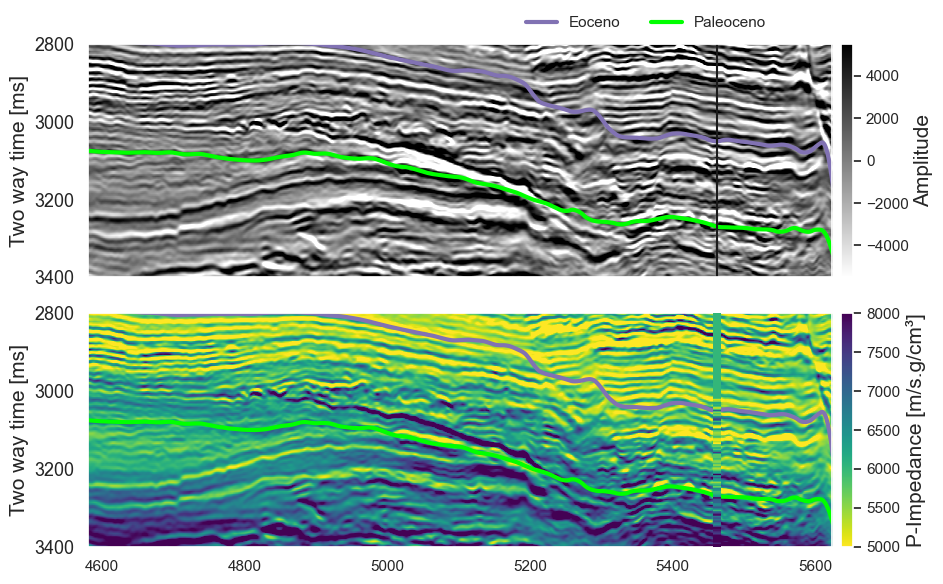

In [28]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

c=axs[0].imshow(amp, aspect='auto', cmap='gray_r', vmin=-5500, vmax=5500, extent=[xl_start, xl_end-3, 3900, 2700])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(minv_tbt, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000, extent=[xl_start, xl_end-3, 3900, 2700])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)
axs[1].imshow(img.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000,
             extent=(5462-5, 5462+5, 3900, 2700), zorder=20)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3400, 2800)
    ax.set_xlim(xl_start, xl_end-3)
    ax.set_yticks(np.arange(2800, 3401, 200))
    ax.set_yticklabels(np.arange(2800, 3401, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 3100].Y, eoceno.loc[eoceno.X == 3100].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 3100].Y, paleoceno.loc[paleoceno.X == 3100].Z,
             color='lime', lw=3.0, label='Paleoceno')
    
    ax.set_ylabel("Two way time [ms]", fontsize=15)
    
    ax.axvline(x=5462, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()

plt.savefig('Figures/inversion_192.png', dpi=200, bbox_inches='tight')

In [29]:
print('Correlation coefficient of trace-by-trace inversion:',
      scipy.stats.pearsonr(df.loc[df.WELL=='1-BRSA-192-ESS'].IP_UPS[88:176],
                           minv_tbt[:, 5462-xl_start][88:176])[0]
)

Correlation coefficient of trace-by-trace inversion: 0.6970920763282642


Text(0, 0.5, 'Acoustic impedance [m/s.g/cm³]')

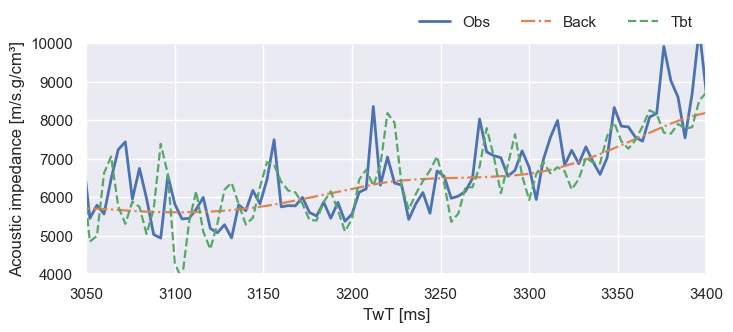

In [30]:
plt.figure(figsize=(8, 3))

plt.plot(df.loc[df.WELL=='1-BRSA-192-ESS'].TWT, df.loc[df.WELL=='1-BRSA-192-ESS'].IP_UPS, label='Obs', lw=2.0)
plt.plot(df.loc[df.WELL=='1-BRSA-192-ESS'].TWT, np.exp(mback[:, 5462-xl_start]), label='Back', lw=1.6, ls='-.')
plt.plot(df.loc[df.WELL=='1-BRSA-192-ESS'].TWT, minv_tbt[:, 5462-xl_start], label='Tbt', lw=1.6, ls='--')
#plt.plot(new_twt, minv_hop[:, 1469-new_xl_start], label='Hor', lw=1.6, ls='--')
#plt.plot(new_twt, minv_dop[:, 1469-new_xl_start], label='Dir', lw=1.6, ls='--')
#plt.plot(new_twt, bsd[1269 - new_il_start, 1469-new_xl_start, :], label='Petrel', lw=1.6, ls='--')

plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), edgecolor='w', facecolor='w', ncol=5)

plt.xlim(3050, 3400)
plt.ylim(4000, 10000)
plt.xlabel('TwT [ms]')
plt.ylabel('Acoustic impedance [m/s.g/cm³]')
#plt.savefig('Figures/inversion_497_well.png', dpi=200, bbox_inches='tight')

(3770.0, 2800.0)

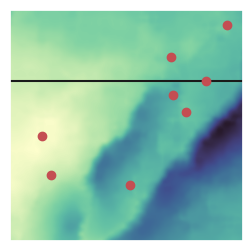

In [31]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(paleoceno['Y'], paleoceno['X'], c=paleoceno['Z'], s=1, cmap=cm.cm.deep)
ax.axhline(3100, color='k')
ax.scatter(5118, 3534, color='r', zorder=20)
ax.scatter(5462, 3100, color='r', zorder=20)
ax.scatter(4722, 3331, color='r', zorder=20)
ax.scatter(4765, 3493, color='r', zorder=20)
ax.scatter(5305, 2996, color='r', zorder=20)
ax.scatter(5370, 3230, color='r', zorder=20)
ax.scatter(5553, 2862, color='r', zorder=20)
ax.scatter(5313, 3157, color='r', zorder=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xl_start, xl_end-3)
ax.set_ylim(il_end, il_start)

Text(0, 0.5, 'Inverted acoustic impedance [m/s.g/cm³]')

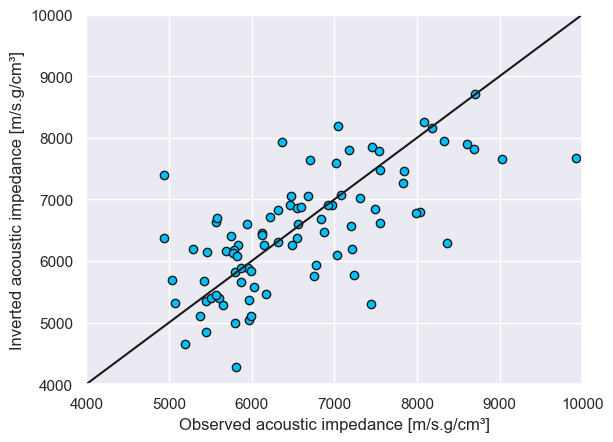

In [32]:
plt.plot([4000, 10000], [4000, 10000], color='k')
plt.scatter(df.loc[df.WELL=='1-BRSA-192-ESS'].IP_UPS[88:176],
            minv_tbt[:, 5462-xl_start][88:176], color='deepskyblue', edgecolor='k')
plt.xlim(4000, 10000)
plt.ylim(4000, 10000)
plt.xlabel('Observed acoustic impedance [m/s.g/cm³]')
plt.ylabel('Inverted acoustic impedance [m/s.g/cm³]')

(3770.0, 2800.0)

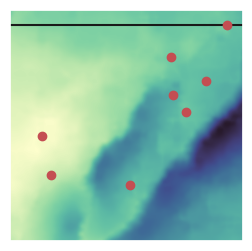

In [148]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(paleoceno['Y'], paleoceno['X'], c=paleoceno['Z'], s=1, cmap=cm.cm.deep)
ax.axhline(2862, color='k')
ax.scatter(5118, 3534, color='r', zorder=20)
ax.scatter(5462, 3100, color='r', zorder=20)
ax.scatter(4722, 3331, color='r', zorder=20)
ax.scatter(4765, 3493, color='r', zorder=20)
ax.scatter(5305, 2996, color='r', zorder=20)
ax.scatter(5370, 3230, color='r', zorder=20)
ax.scatter(5553, 2862, color='r', zorder=20)
ax.scatter(5313, 3157, color='r', zorder=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xl_start, xl_end-3)
ax.set_ylim(il_end, il_start)

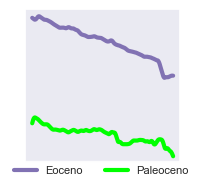

In [50]:
fig, ax = plt.subplots(figsize=(2, 2))

ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
         color='m', lw=3.0, label='Eoceno')
ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
         color='lime', lw=3.0, label='Paleoceno')
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])

ax.legend(fontsize=8, edgecolor='w', facecolor='w', ncol=2, bbox_to_anchor=[1.12, 0.05])

In [347]:
# Inverting at well 55 inline

# Seismic amplitude section
amp = data[3157 - 2800, :, 675:975].T
print("Shape of data [n_samples, n_traces]:", amp.shape)
# Log of the low frequency model of impedance
mback = np.log(lowf[2862 - 2800, :-3, 675:975].T)
# Wavelet operator
nz, nx = amp.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace
minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,
    y=amp.ravel() / 30000,
    Regs=None,
    epsI=5e-1,
    x0=mback.ravel(),
    engine='scipy',
    **dict(maxiter=1000))
minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))

Shape of data [n_samples, n_traces]: (300, 1048)


In [348]:
img = np.tile(df.loc[df.WELL=='6-BRSA-639-ESS'].IP_UPS, (100, 1))

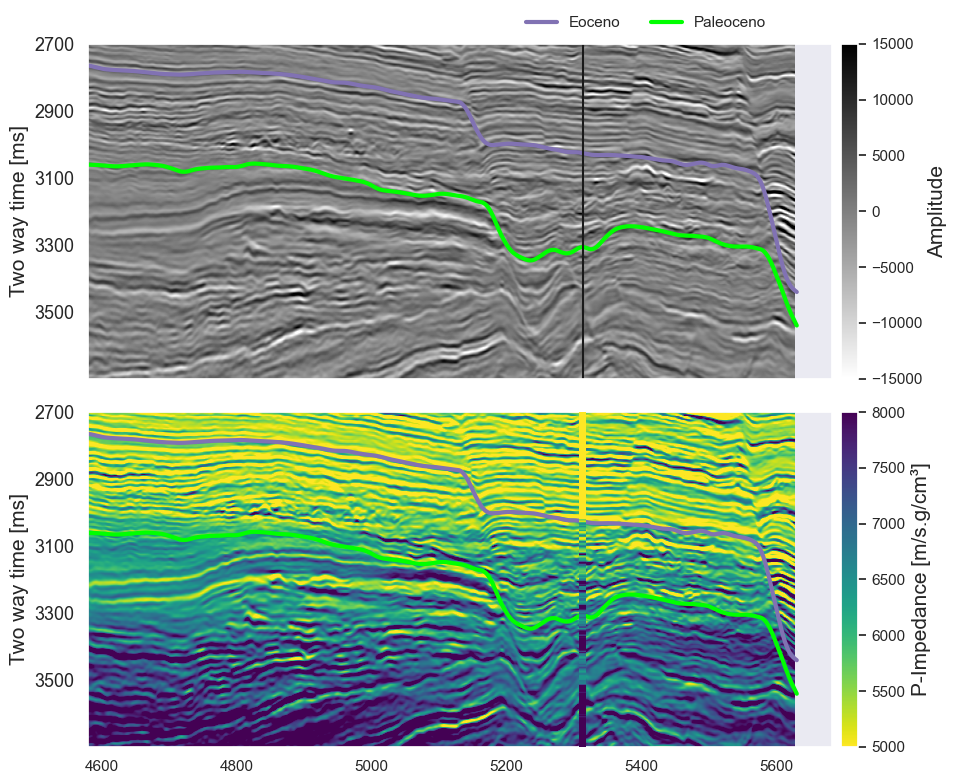

In [349]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

c=axs[0].imshow(amp, aspect='auto', cmap='gray_r', vmin=-15000, vmax=15000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(minv_tbt, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)
axs[1].imshow(img.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000,
             extent=(5313-5, 5313+5, 3900, 2700), zorder=20)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3700, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 3157].Y, eoceno.loc[eoceno.X == 3157].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 3157].Y, paleoceno.loc[paleoceno.X == 3157].Z,
             color='lime', lw=3.0, label='Paleoceno')
    
    ax.set_ylabel("Two way time [ms]", fontsize=15)
    
    ax.axvline(x=5313, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()

plt.savefig('Figures/inversion_639.png', dpi=200, bbox_inches='tight')

In [350]:
# Trace-by-trace in the whole 3D volume

ip_volume = np.full_like(data, np.nan)

for i in range(data.shape[0]):
    amp = data[i, :, 675:975].T
    # Log of the low frequency model of impedance
    mback = np.log(lowf[i, :-3, 675:975].T)
    # Wavelet operator
    nz, nx = amp.shape
    PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                         nt0=nz,
                                                         spatdims=nx,
                                                         explicit=True)

    # Trace-by-trace
    minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
        Op=PPop,
        y=amp.ravel() / 30000,
        Regs=None,
        epsI=5e-1,
        x0=mback.ravel(),
        **dict(maxiter=1000))
    minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))
    ip_volume[i, :, 675:975] = minv_tbt.T
    
    print(f'Running IL {i+1}/{data.shape[0]}\r', end="")

In [351]:
flat_volume = np.reshape(ip_volume, (ip_volume.shape[0]*ip_volume.shape[1], -1))

In [352]:
# Saving data: write segy

with segyio.open(filename) as src:
    spec = segyio.spec()
    spec.sorting = src.sorting
    spec.format = src.format
    spec.samples = src.samples
    spec.ilines = src.ilines
    spec.xlines = src.xlines
    print(len(spec.ilines), len(spec.xlines), len(spec.samples))
    
    with segyio.create('Impedancia/Impedance_Tikho_Tbt_PRECOND.sgy', spec) as dst:
        tr = 0
        for il in spec.ilines:
            for xl in spec.xlines:
                dst.header[tr] = {
                    segyio.su.iline  : il,
                    segyio.su.xline  : xl}

                dst.trace[tr] = flat_volume[tr]
                tr += 1
                    
        dst.bin.update(
            tsort=segyio.TraceSortingFormat.INLINE_SORTING
        )

971 1048 1751


In [152]:
positions = np.array(([3534 - il_start, 5118 - xl_start],
    [3100 - il_start, 5462 - xl_start],
    [3331 - il_start, 4722 - xl_start],
    [3493 - il_start, 4765 - xl_start],
    [2996 - il_start, 5305 - xl_start],
    [3230 - il_start, 5370 - xl_start],
    [2862 - il_start, 5553 - xl_start],
    [3157 - il_start, 5313 - xl_start]))

r108a = round(scipy.stats.pearsonr(df.loc[df.WELL=='1-BRSA-108A-ESS'].IP_UPS[62:],
                                   ip_volume[positions[0][0], positions[0][1], (2700//4):(3900//4)][62:])[0], 2)

r192 = round(scipy.stats.pearsonr(df.loc[df.WELL=='1-BRSA-192-ESS'].IP_UPS[88:176],
                                   ip_volume[positions[1][0], positions[1][1], (2700//4):(3900//4)][88:176])[0], 2)

r33 = round(scipy.stats.pearsonr(df.loc[df.WELL=='1-BRSA-33-ESS'].IP_UPS[12:267],
                                   ip_volume[positions[2][0], positions[2][1], (2700//4):(3900//4)][12:267])[0], 2)

r168 = round(scipy.stats.pearsonr(df.loc[df.WELL=='3-BRSA-168-ESS'].IP_UPS[25:177],
                                   ip_volume[positions[3][0], positions[3][1], (2700//4):(3900//4)][25:177])[0], 2)

r177 = round(scipy.stats.pearsonr(df.loc[df.WELL=='3-BRSA-177-ESS'].IP_UPS[62:170],
                                   ip_volume[positions[4][0], positions[4][1], (2700//4):(3900//4)][62:170])[0], 2)

r291d = round(scipy.stats.pearsonr(df.loc[df.WELL=='4-BRSA-291D-ESS'].IP_UPS[81:280],
                                   ip_volume[positions[5][0], positions[5][1], (2700//4):(3900//4)][81:280])[0], 2)

r497 = round(scipy.stats.pearsonr(df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS[100:200],
                                   ip_volume[positions[6][0], positions[6][1], (2700//4):(3900//4)][100:200])[0], 2)

r639 = round(scipy.stats.pearsonr(df.loc[df.WELL=='6-BRSA-639-ESS'].IP_UPS[77:],
                                   ip_volume[positions[7][0], positions[7][1], (2700//4):(3900//4)][77:])[0], 2)

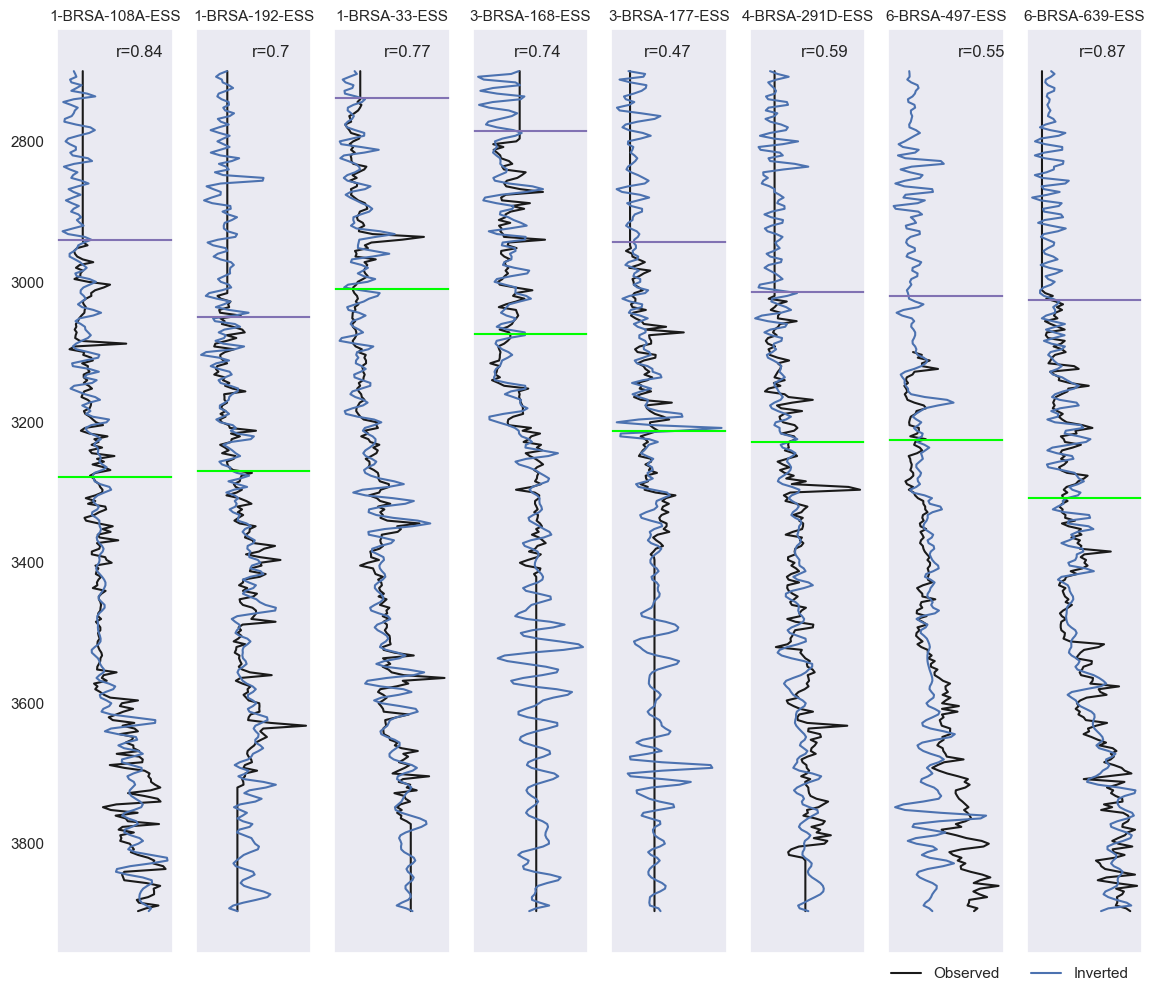

In [153]:


fig, ax = plt.subplots(1, 8, figsize=(14, 12), sharey=True)

for idx, well in enumerate(df.WELL.unique()):
    ax[idx].plot(df.loc[df.WELL==well, 'IP_UPS'], df.loc[df.WELL==well, 'TWT'],
                 color='k', label='Observed')
    ax[idx].plot(ip_volume[positions[idx][0], positions[idx][1], :], twt, label='Inverted')
    ax[idx].axhline(eoceno.loc[(eoceno.X==positions[idx][0]+il_start) & (eoceno.Y==positions[idx][1]+xl_start)].Z.to_numpy(),
                    color='m')
    ax[idx].axhline(paleoceno.loc[(paleoceno.X==positions[idx][0]+il_start) & (paleoceno.Y==positions[idx][1]+xl_start)].Z.to_numpy(),
                    color='lime')
    ax[idx].set_title(well, fontsize=11)
    ax[idx].grid(False)
    ax[idx].set_xticks([])
ax[0].invert_yaxis()
ax[7].legend(loc='upper center', bbox_to_anchor=(-0.15, -0.0), ncol=2, facecolor='w', edgecolor='w')

ax[0].text(9000, 2680, f'r={r108a}')
ax[1].text(8000, 2680, f'r={r192}')
ax[2].text(8000, 2680, f'r={r33}')
ax[3].text(6000, 2680, f'r={r168}')
ax[4].text(6000, 2680, f'r={r177}')
ax[5].text(8000, 2680, f'r={r291d}')
ax[6].text(10000, 2680, f'r={r497}')
ax[7].text(8000, 2680, f'r={r639}')

plt.savefig('Figures/inversion_all_wells_logplot.png', dpi=200, bbox_inches='tight')

In [160]:
eocene_surface = eoceno['Z'].to_numpy().reshape((971, 1051))[:, :-3]
paleocene_surface = paleoceno['Z'].to_numpy().reshape((971, 1051))[:, :-3]

In [161]:
# Maps
map_eocene = np.full((971, 1048), np.nan)
map_paleocene = np.full((971, 1048), np.nan)

for i in range(0, 971):
    for j in range(0, 1048):
        map_eocene[i, j] = np.mean(ip_volume[i, j,
                                   int(eocene_surface[i, j]//4):int(eocene_surface[i, j]//4 + 10)])
        map_paleocene[i, j] = np.mean(ip_volume[i, j,
                                      int(paleocene_surface[i, j]//4 - 10):int(paleocene_surface[i, j]//4)])

In [272]:
import matplotlib.colors as colors

# create a list of hexadecimal color codes
hex_colors = ['#631213', '#A92219', '#E42B19', '#FF2E17', '#FF4F1C', '#FF8427', '#FFB031', 
              '#FFDB3B', '#F1E443', '#B8D544', '#78C647', '#5BBE49', '#3BB851', '#1F8781',
              '#1451AC', '#1F4AA7', '#2148A5', '#30319A']

# create a list of normalized values from 0 to 1
values = np.linspace(0, 1, len(hex_colors))

# create a dictionary with the color values for each segment
colors_dict = {value: color for value, color in zip(values, hex_colors)}

# create a LinearSegmentedColormap using the dictionary of color values
cmap = colors.LinearSegmentedColormap.from_list('my_cmap', list(colors_dict.items()))

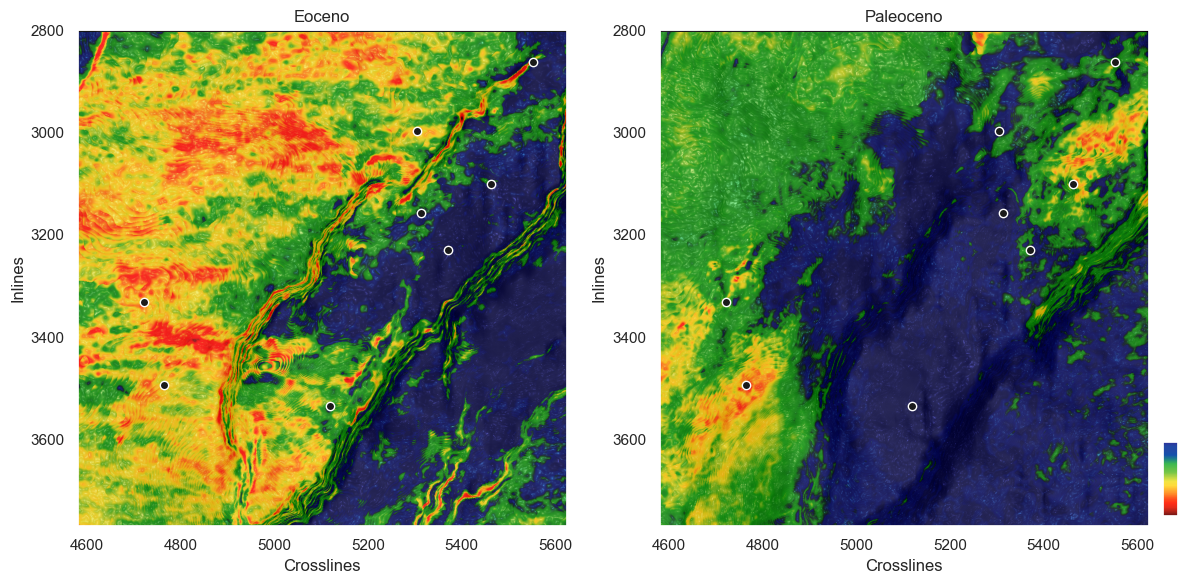

In [346]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im = ax[1].imshow(map_paleocene, cmap=cmap)
im.remove()
axin1 = ax[1].inset_axes([1.03, 0.02, 0.03, 0.15])
axin1.grid(False)
axin1.set(xticks=[],
          yticks=[])
plt.colorbar(im, cax=axin1, ticks=[])

ls = colors.LightSource(azdeg = 90, altdeg = 90)
rgb = ls.shade(map_eocene, cmap=cmap, blend_mode='overlay', vmin=5000, vmax=6000,
               vert_exag=1)
ax[0].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start], cmap=cmap)

ls = colors.LightSource(azdeg = 90, altdeg = 45)
rgb = ls.hillshade(eocene_surface, vert_exag=1)
c0=ax[0].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start],
                cmap='gray', alpha=0.15)


ls = colors.LightSource(azdeg = 90, altdeg = 90)
rgb = ls.shade(map_paleocene, cmap=cmap, blend_mode='overlay', vmin=5000, vmax=7000,
               vert_exag=1)
ax[1].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start], cmap=cmap)

ls = colors.LightSource(azdeg = 90, altdeg = 45)
rgb = ls.hillshade(paleocene_surface, vert_exag=1)
c0=ax[1].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start],
                cmap='gray', alpha=0.15)

for axs in fig.get_axes():
    axs.grid(False)
    axs.set_xlabel('Crosslines')
    axs.set_ylabel('Inlines')
    axs.scatter(5118, 3534, color='k', zorder=20, edgecolor='w')
    axs.scatter(5462, 3100, color='k', zorder=20, edgecolor='w')
    axs.scatter(4722, 3331, color='k', zorder=20, edgecolor='w')
    axs.scatter(4765, 3493, color='k', zorder=20, edgecolor='w')
    axs.scatter(5305, 2996, color='k', zorder=20, edgecolor='w')
    axs.scatter(5370, 3230, color='k', zorder=20, edgecolor='w')
    axs.scatter(5553, 2862, color='k', zorder=20, edgecolor='w')
    axs.scatter(5313, 3157, color='k', zorder=20, edgecolor='w')
    axs.set_xlim(xl_start, xl_end-3)
    axs.set_ylim(il_end, il_start)
    
ax[0].set_title('Eoceno')
ax[1].set_title('Paleoceno')

plt.tight_layout()

plt.savefig('Figures/maps.png', dpi=250, bbox_inches='tight')